In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D,Conv3D, BatchNormalization, Activation, Add, MaxPool3D, Dense, GlobalAveragePooling3D
from keras.models import load_model
import nibabel as nib
from scipy import ndimage
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def conv3x3(filters, stride=1):
    return Conv3D(filters, kernel_size=(3,3,3), strides=stride, padding='same', use_bias=False)

def residual_block(x, filters, downsample=False):
    shortcut = x
    stride = 1
    if downsample:
        stride = 2
        shortcut = Conv3D(filters, kernel_size=(1,1,1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = conv3x3(filters, stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv3x3(filters)(x)
    x = BatchNormalization()(x)
    # if shortcut.shape[-1] != x.shape[-1]:
    #     x = tf.keras.layers.Conv3D(filters=shortcut.shape[-1], kernel_size=1)(x)    
    print(x.shape,shortcut.shape)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet10(input_shape=(224,224,224), num_classes=1000):
    inputs = Input(shape=input_shape)
    
    x = conv3x3(64, stride=2)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)
    
    x = GlobalAveragePooling3D()(x)

    x = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, x)
    return model

# # Define function to load and preprocess images
# def load_and_preprocess_image(image_path):
#     # Load image
#     img = load_img(image_path, target_size=(96, 96))
#     # Convert image to array
#     img_arr = img_to_array(img)
#     # Normalize pixel values
#     img_arr = img_arr / 255.0
#     # Return preprocessed image
#     return img_arr

def load_and_preprocess_image(path):
    # load the .nii.gz file
    img = nib.load(path)

    # get the image data and header
    img_data = img.get_fdata()
    img_header = img.header

    # resize the image to (96, 96, 96)
    img_resized = ndimage.zoom(img_data, (96 / img_data.shape[0], 96 / img_data.shape[1], 96 / img_data.shape[2]), order=1)

    # convert the image to an array and normalize it
    img_array = np.asarray(img_resized, dtype=np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    img_array_norm = (img_array - img_min) / (img_max - img_min)

    return img_array_norm

In [ ]:
# Define paths to image directory and label csv file
image_dir = '/content/drive/MyDrive/Abide_Data'
label_file = '/content/drive/MyDrive/B.Tech/abide_label_niigz.csv'

# Load label csv file
labels_df = pd.read_csv(label_file)

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop over each row in the label csv file and extract image path and label
for index, row in labels_df.iterrows():
    image_name = row['image_name']
    label = row['label']
    image_path = os.path.join(image_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into training and testing sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [ ]:
# Load and preprocess training images
train_images = []
for image_path in train_image_paths:
    img = load_and_preprocess_image(image_path)
    train_images.append(img)
train_images = np.array(train_images)

# Load and preprocess testing images
test_images = []
for image_path in test_image_paths:
    img = load_and_preprocess_image(image_path)
    test_images.append(img)
test_images = np.array(test_images)

In [ ]:
# import matplotlib.pyplot as plt

# img_data = train_images[0]

# # Select a slice along the z-axis
# z_slice = 50
# slice_data = img_data[:, :, z_slice]

# # Plot the selected slice
# fig, ax = plt.subplots()
# ax.imshow(slice_data, cmap='gray')
# ax.set_title('Slice {} of 3D image'.format(z_slice))
# plt.show()


In [ ]:
# # Save preprocessed images as numpy arrays
# np.save('train_images.npy', train_images)
# np.save('test_images.npy', test_images)
# np.save('train_labels.npy', train_labels)
# np.save('test_labels.npy', test_labels)


In [ ]:
# train_images = np.load('train_images.npy')
# test_images = np.load('test_images.npy')

In [ ]:
model = ResNet10(input_shape=(96, 96, 96,1), num_classes=2)
model.summary()

(None, 48, 48, 48, 64) (None, 48, 48, 48, 64)
(None, 24, 24, 24, 128) (None, 24, 24, 24, 128)
(None, 24, 24, 24, 128) (None, 24, 24, 24, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 48, 48, 48,   1728        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 48,

In [ ]:
# Compile the model
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()

In [ ]:
# Define some callbacks
early_stop = EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='best_model_abide_resnet.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stop, checkpointer])

Epoch 1/20
3/3 [==============================] - 6s 2s/step - loss: 1.3833 - accuracy: 0.4474 - val_loss: 31.5588 - val_accuracy: 0.5500
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 0.7051 - accuracy: 0.5132 - val_loss: 7.9399 - val_accuracy: 0.5500
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 0.7790 - accuracy: 0.5526 - val_loss: 8.5318 - val_accuracy: 0.5500
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 0.7433 - accuracy: 0.5132 - val_loss: 1.8504 - val_accuracy: 0.5500
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.7771 - accuracy: 0.4737 - val_loss: 1.2583 - val_accuracy: 0.5500
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 0.6996 - accuracy: 0.5789 - val_loss: 0.9137 - val_accuracy: 0.5500
Epoch 7/20
3/3 [==============================] - 6s 2s/step - loss: 0.6723 - accuracy: 0.5395 - val_loss: 0.7071 - val_accuracy: 0.5500
Epoch 8/20
3/3 [========================

In [ ]:
# from matplotlib import pyplot as plt

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
best_model = load_model('best_model_abide_resnet.h5')

# Evaluate the model on the testing set
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

1/1 [==============================] - 3s 3s/step - loss: 0.8368 - accuracy: 0.3750
Test loss: 0.8367533683776855
Test accuracy: 0.375


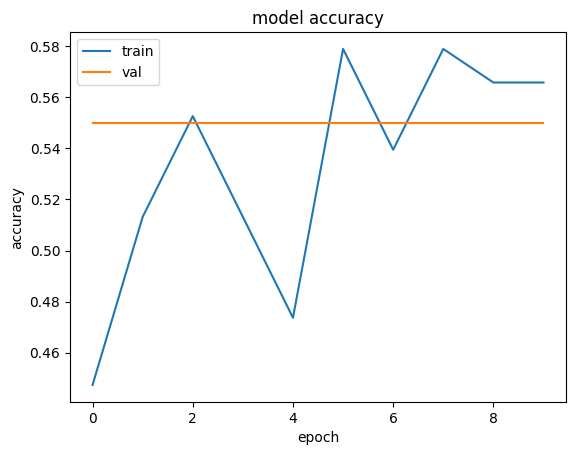

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

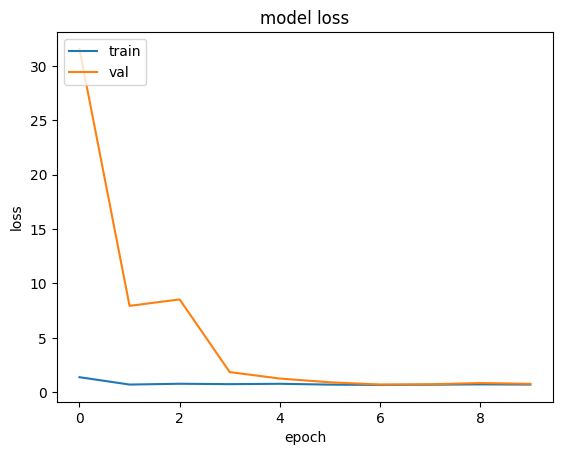

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
result = model.predict(test_images,)
y_test = np.argmax(result, axis=1)


1/1 [==============================] - 0s 432ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are the true and predicted labels, respectively
y_true = test_labels
y_pred = y_test

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[ 0 15]
 [ 0  9]]


In [ ]:
# Loop over the rows and columns of the confusion matrix to extract TP, TN, FP, and FN numbers for each class
for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    print(f"Class {i+1}")
    print("True Positives (TP): ", tp)
    print("True Negatives (TN): ", tn)
    print("False Positives (FP): ", fp)
    print("False Negatives (FN): ", fn)

Class 1
True Positives (TP):  0
True Negatives (TN):  9
False Positives (FP):  0
False Negatives (FN):  15
Class 2
True Positives (TP):  9
True Negatives (TN):  0
False Positives (FP):  15
False Negatives (FN):  0


In [ ]:
from sklearn.metrics import classification_report

# Get the classification report

cr = classification_report(y_true, y_pred, digits=4)

print(cr)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        15
           1     0.3750    1.0000    0.5455         9

    accuracy                         0.3750        24
   macro avg     0.1875    0.5000    0.2727        24
weighted avg     0.1406    0.3750    0.2045        24



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
